In [12]:
import pandas as pd
!pip install tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

url = 'https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/refs/heads/master/data/labeled_data.csv'
df = pd.read_csv(url)

X = df['tweet']
y = df['class']

le = LabelEncoder()
y = le.fit_transform(y)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, padding='post', maxlen=100)

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)


In [ ]:
def create_model(filters=128, kernel_size=5, pool_size=4, dense_units=128, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model = create_model()
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


310/310 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.8207 - loss: 0.5259 - val_accuracy: 0.8991 - val_loss: 0.3156
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.9156 - loss: 0.2619 - val_accuracy: 0.8983 - val_loss: 0.3012
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.9365 - loss: 0.1802 - val_accuracy: 0.8931 - val_loss: 0.3464
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9547 - loss: 0.1211 - val_accuracy: 0.8899 - val_loss: 0.4126
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.9720 - loss: 0.0803 - val_accuracy: 0.8836 - val_loss: 0.5466


Running model with filters=64, kernel_size=3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Running model with filters=128, kernel_size=5
Running model with filters=256, kernel_size=3


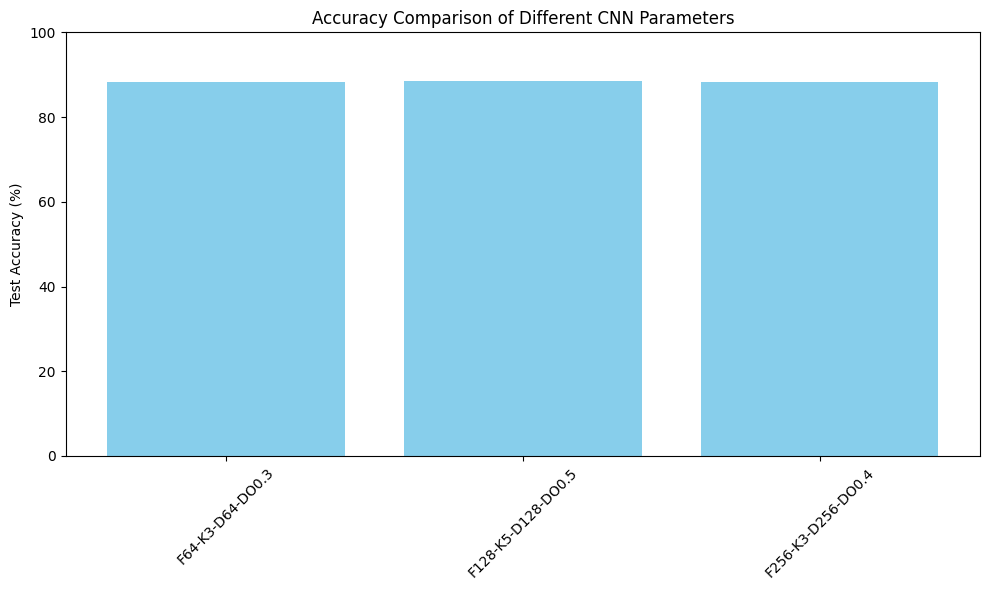

In [14]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def run_experiment(filters, kernel_size, dense_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), verbose=0)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return test_accuracy, history

experiments = [
    {"filters": 64, "kernel_size": 3, "dense_units": 64, "dropout_rate": 0.3},
    {"filters": 128, "kernel_size": 5, "dense_units": 128, "dropout_rate": 0.5},
    {"filters": 256, "kernel_size": 3, "dense_units": 256, "dropout_rate": 0.4}
]

results = []
histories = []

for exp in experiments:
    print(f"Running model with filters={exp['filters']}, kernel_size={exp['kernel_size']}")
    acc, history = run_experiment(**exp)
    results.append((exp, acc))
    histories.append(history)

labels = [f"F{e['filters']}-K{e['kernel_size']}-D{e['dense_units']}-DO{e['dropout_rate']}" for e, _ in results]
accuracies = [round(acc * 100, 2) for _, acc in results]

plt.figure(figsize=(10,6))
plt.bar(labels, accuracies, color='skyblue')
plt.ylim(0, 100)
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy Comparison of Different CNN Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate

headers = ["Filters", "Kernel Size", "Dense Units", "Dropout Rate", "Accuracy (%)"]
formatted_results = [
    [exp['filters'], exp['kernel_size'], exp['dense_units'], exp['dropout_rate'], round(acc * 100, 2)]
    for exp, acc in results
]

print(tabulate(formatted_results, headers=headers, tablefmt="github"))


|   Filters |   Kernel Size |   Dense Units |   Dropout Rate |   Accuracy (%) |
|-----------|---------------|---------------|----------------|----------------|
|        64 |             3 |            64 |            0.3 |          88.26 |
|       128 |             5 |           128 |            0.5 |          88.62 |
|       256 |             3 |           256 |            0.4 |          88.28 |


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)

target_names = ['hate speech', 'offensive language', 'neither']

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Classification Report:
                    precision    recall  f1-score   support

       hate speech       0.39      0.23      0.29       290
offensive language       0.91      0.95      0.93      3832
           neither       0.83      0.82      0.83       835

          accuracy                           0.88      4957
         macro avg       0.71      0.66      0.68      4957
      weighted avg       0.87      0.88      0.88      4957



155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test Accuracy: 88.36%


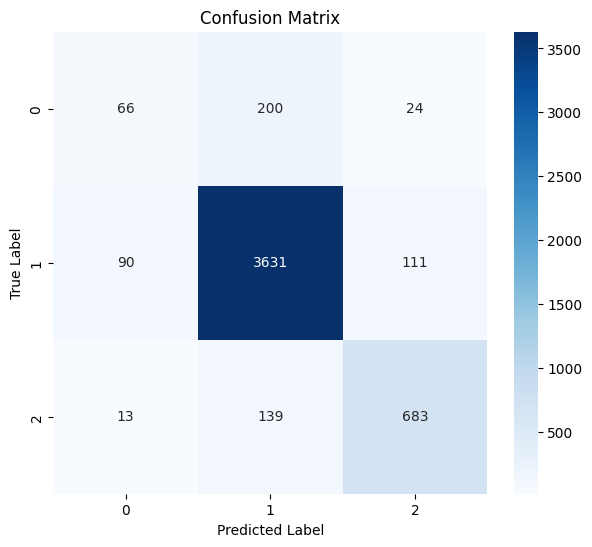

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy*100:.2f}%')

cm = confusion_matrix(y_test, y_pred)
cm_labels = le.classes_

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_labels, yticklabels=cm_labels, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


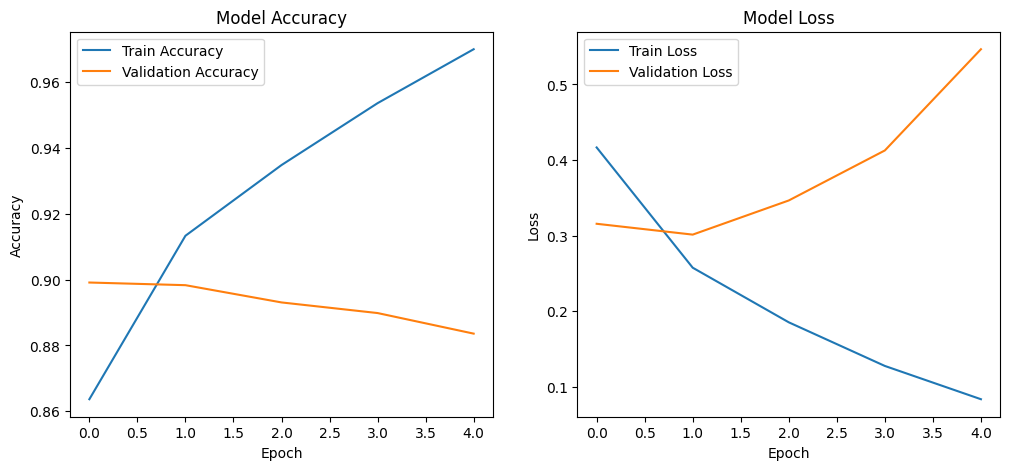

In [ ]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
